# Make A Data Cleaning Agent <a id="make-a-data-cleaning-agent"></a>

### Free Generative AI Data Science Workshop

If you want to learn how to build AI Agents that perform Data Science, Business Intelligence, Churn Modeling, Time Series Forecasting, and more, [register for my next free AI for Data Scientists workshop here.](https://learn.business-science.io/ai-register)


# Table of Contents

1. [Make A Data Cleaning Agent](#make-a-data-cleaning-agent)
2. [Load Libraries](#load-libraries)
3. [Setup AI and Logging](#setup-ai-and-logging)
4. [Load a Dataset](#load-a-dataset)
5. [Create The Agent](#create-the-agent)
6. [Response](#response)
7. [The cleaning recipe](#the-cleaning-recipe)
8. [Data Cleaner Function](#data-cleaner-function)
9. [Cleaned Data As Pandas Data Frame](#cleaned-data-as-pandas-data-frame)
10. [Free Generative AI Data Science Workshop](#free-generative-ai-data-science-workshop)

### Load Libraries <a id="load-libraries"></a>

In [10]:
# * Libraries

from langchain_openai import ChatOpenAI
import os
import yaml
import pandas as pd
from pprint import pprint

from ai_data_science_team.agents import make_data_cleaning_agent
from ai_data_science_team.utils import get_mermaid_flowchart

### Setup AI and Logging <a id="setup-ai-and-logging"></a>

This section of code sets up the LLM inputs and the logging information. Logging is used to store AI-generated code and files during the AI Data Science Teams processing of files. 

*Important Note:* This example uses OpenAI's API. But any LLM can be used such as Anthropic or local LLMs with Ollama.

In [4]:
# * Setup

MODEL    = "gpt-4o-mini"
LOG      = True
LOG_PATH = os.path.join(os.getcwd(), "logs/")

os.environ["OPENAI_API_KEY"] = yaml.safe_load(open('../credentials.yml'))['openai']

llm = ChatOpenAI(model = MODEL)

llm


ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7f9078f56cb0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7f90d915f310>, root_client=<openai.OpenAI object at 0x7f90b8477ac0>, root_async_client=<openai.AsyncOpenAI object at 0x7f9078f56e90>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'))

### Load a Dataset <a id="load-a-dataset"></a>

Next, let's load a customer churn data set that we will clean up. 

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/business-science/ai-data-science-team/refs/heads/master/data/churn_data.csv")
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


### Create The Agent <a id="create-the-agent"></a>

Run this code to create an agent with `make_data_cleaning_agent()`.

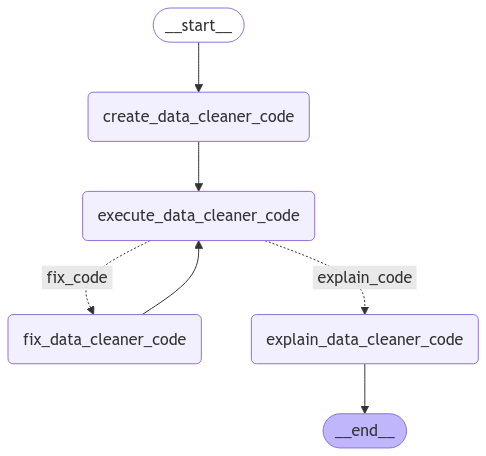

In [11]:
data_cleaning_agent = make_data_cleaning_agent(model = llm, log=LOG, log_path=LOG_PATH)

get_mermaid_flowchart(data_cleaning_agent)

This creates an `app`, which is a langgraph agent with the main inputs:

- **user_instructions**: The data cleaning agent will use these comments to modify the "standard recipe" 
  - Standard Recipe: The standard cleaning recipe which includes removing columns with more than 40% missing values, imputing missing values using mean (numeric) or mode (categorical), removing duplicate rows, and removing outliers. 
- **data_raw**: The raw data to be cleaned
- **max_retries**: Used to limit the number of attempts to fix the python code generated by the agent. Set this to 3 to limit to 3 attempts. 
- **retry_count**: Set this to 0. 

In [5]:

response = data_cleaning_agent.invoke({
    "user_instructions": "Don't remove outliers when cleaning the data.",
    "data_raw": df.to_dict(),
    "max_retries":3, 
    "retry_count":0
})

---DATA CLEANING AGENT----
    * CREATE DATA CLEANER CODE
    * EXECUTING AGENT CODE
    * EXPLAIN AGENT CODE


### Response <a id="response"></a>

The response produced contains everything we need to understand the data cleaning decisions made and get the cleaned dataset. 

In [6]:
list(response.keys())

['messages',
 'user_instructions',
 'data_raw',
 'data_cleaner_function',
 'data_cleaner_error',
 'data_cleaned',
 'max_retries',
 'retry_count']

### The cleaning recipe <a id="the-cleaning-recipe"></a>

In [7]:
pprint(response['messages'][0].content)


('# Data Cleaning Agent:\n'
 '\n'
 ' The data cleaning steps performed in the `data_cleaner` function are as '
 'follows:\n'
 '\n'
 '1. **Remove Columns with Excessive Missing Values**: Columns with more than '
 '40% missing values are dropped to retain only useful data.\n'
 '\n'
 '2. **Impute Missing Values for Numeric Columns**: Missing values in numeric '
 'columns are filled with the mean of those columns using `SimpleImputer`.\n'
 '\n'
 '3. **Impute Missing Values for Categorical Columns**: Missing values in '
 'categorical columns are filled with the mode (most frequent value) using a '
 'separate `SimpleImputer`.\n'
 '\n'
 "4. **Convert Data Types**: The 'TotalCharges' column is converted to a "
 'numeric type to handle any non-numeric entries by coercing errors to NaN.\n'
 '\n'
 '5. **Remove Duplicate Rows**: Duplicate rows in the dataset are removed to '
 'ensure unique entries.\n'
 '\n'
 '6. **Remove Rows with Remaining Missing Values**: Any rows that still '
 'contain missin

#### Data Cleaner Function <a id="data-cleaner-function"></a>

In [8]:
pprint(response['data_cleaner_function'])

('def data_cleaner(data_raw):\n'
 '    import pandas as pd\n'
 '    import numpy as np\n'
 '    from sklearn.impute import SimpleImputer\n'
 '\n'
 '\n'
 '\n'
 '    # Step 1: Remove columns with more than 40% missing values\n'
 '    threshold = 0.4 * len(data_raw)\n'
 '    data_cleaned = data_raw.dropna(axis=1, thresh=threshold)\n'
 '\n'
 '    # Step 2: Impute missing values for numeric columns with mean\n'
 '    numeric_cols = '
 'data_cleaned.select_dtypes(include=np.number).columns.tolist()\n'
 "    imputer_numeric = SimpleImputer(strategy='mean')\n"
 '    data_cleaned[numeric_cols] = '
 'imputer_numeric.fit_transform(data_cleaned[numeric_cols])\n'
 '\n'
 '    # Step 3: Impute missing values for categorical columns with mode\n'
 '    categorical_cols = '
 "data_cleaned.select_dtypes(include='object').columns.tolist()\n"
 "    imputer_categorical = SimpleImputer(strategy='most_frequent')\n"
 '    data_cleaned[categorical_cols] = '
 'imputer_categorical.fit_transform(data_cleaned[categ

#### Cleaned Data As Pandas Data Frame <a id="cleaned-data-as-pandas-data-frame"></a>

In [9]:
pd.DataFrame(response['data_cleaned'])


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0.0,Yes,No,1.0,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0.0,No,No,34.0,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0.0,No,No,2.0,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0.0,No,No,45.0,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0.0,No,No,2.0,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,Male,0.0,Yes,Yes,24.0,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7028,2234-XADUH,Female,0.0,Yes,Yes,72.0,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7029,4801-JZAZL,Female,0.0,Yes,Yes,11.0,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7030,8361-LTMKD,Male,1.0,Yes,No,4.0,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


### Free Generative AI Data Science Workshop <a id="free-generative-ai-data-science-workshop"></a>

If you want to learn how to build AI Agents that perform Data Science, Business Intelligence, Churn Modeling, Time Series Forecasting, and more, [register for my next free AI for Data Scientists workshop here.](https://learn.business-science.io/ai-register)